In [ ]:
# === Imports ===
import os
import pandas as pd
import kagglehub
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
from imblearn.over_sampling import SMOTE
import joblib
from xgboost import XGBClassifier

# === Create necessary folders ===
os.makedirs("models", exist_ok=True)
os.makedirs("results", exist_ok=True)

from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Loading Data and Preprocessing

In [ ]:

# Download dataset from Kaggle
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
# Load the dataset using the full path
df = pd.read_csv(f"{path}/creditcard.csv")
# features and target
X = df.drop('Class', axis=1)
y = df['Class']

# Feature scaling for 'Amount' and 'Time'
scaler = StandardScaler()
X[['Time', 'Amount']] = scaler.fit_transform(X[['Time', 'Amount']])


# Save to root of /content
joblib.dump(scaler, "scaler.pkl")


#Split and train data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:
import os
print(os.listdir())

['.config', 'drive', 'models', 'scaler.pkl', 'results', 'sample_data']


Using SMOTE

In [ ]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", np.bincount(y_train))
print("After SMOTE:", np.bincount(y_resampled))


Before SMOTE: [227451    394]
After SMOTE: [227451 227451]



# I/ Logistic Regression as Model:


In [ ]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_resampled, y_resampled)

y_pred = lr.predict(X_test)
y_proba = lr.predict_proba(X_test)[:, 1]


# Save model to Google Drive
os.makedirs("/content/drive/My Drive/models", exist_ok=True)
joblib.dump(lr, "/content/drive/My Drive/models/logistic_model.pkl")


['/content/drive/My Drive/models/logistic_model.pkl']

Evaluation:

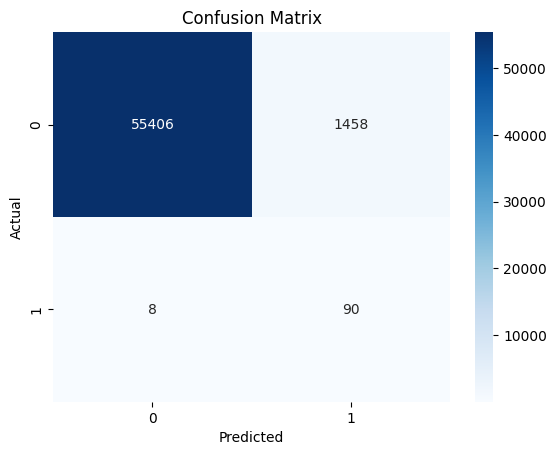

              precision    recall  f1-score   support

           0     0.9999    0.9744    0.9869     56864
           1     0.0581    0.9184    0.1094        98

    accuracy                         0.9743     56962
   macro avg     0.5290    0.9464    0.5481     56962
weighted avg     0.9982    0.9743    0.9854     56962

ROC-AUC Score: 0.9698


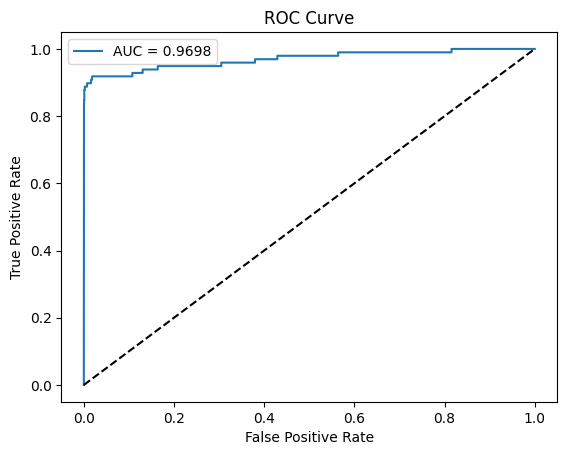

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report
print(classification_report(y_test, y_pred, digits=4))
# ROC-AUC
auc = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC Score: {auc:.4f}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


# II/ XGBoost Model for training :

In [ ]:
# XGBoost Parameter Grid
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3],
    'scale_pos_weight': [1, 10, 20, 50]  # for imbalance
}


XGBoost Classifier :

In [ ]:
# Create XGBoost model with basic config
xgb = XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='auc',
    random_state=42
)

# Randomized search for speed
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=25,         # Not too big, not too small → 10-15 min expected
    scoring='roc_auc', # Works well for imbalance
    cv=3,              # Balanced tradeoff between accuracy & time
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit the model on SMOTE-balanced training set
random_search.fit(X_resampled, y_resampled)
# Get the best estimator
best_xgb = random_search.best_estimator_
print("Best XGBoost Parameters:\n", random_search.best_params_)


Fitting 3 folds for each of 25 candidates, totalling 75 fits


KeyboardInterrupt: 

In [ ]:
#Storing results
results_df = pd.DataFrame(random_search.cv_results_)
results_df.to_csv("results/xgboost_tuning_results.csv", index=False)

Predictions and Evaluation:

In [ ]:
# Predict on test set
y_pred_xgb = best_xgb.predict(X_test)
y_proba_xgb = best_xgb.predict_proba(X_test)[:, 1]

# Confusion matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Purples')
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred_xgb, digits=4))

# ROC AUC
auc_xgb = roc_auc_score(y_test, y_proba_xgb)
print(f"XGBoost ROC-AUC Score: {auc_xgb:.4f}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba_xgb)
plt.plot(fpr, tpr, label=f"AUC = {auc_xgb:.4f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("XGBoost ROC Curve")
plt.legend()
plt.show()


Saving model:

In [ ]:
# Save Best XGBoost Model
os.makedirs("models", exist_ok=True)
joblib.dump(best_xgb, "models/xgboost_model.pkl")


In [ ]:
import os
import joblib

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Create folder in your Drive if not exists
save_path = "/content/drive/My Drive/models"
os.makedirs(save_path, exist_ok=True)

# Save model to Google Drive
joblib.dump(best_xgb, f"{save_path}/xgboost_model.pkl")


